# Attention readout and visualisation

In [ ]:
!pip install rdkit
!pip install prody
!pip install biopython
!pip install cairosvg

In [ ]:
import pandas as pd
from prody import *
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit import RDConfig
import os
import sys
#plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import namedtuple
import torch
from IPython.display import SVG
import cairosvg
from IPython.display import Image, display
import io
import numpy as np

In [ ]:
'''to import to get attention from model
from attention_readout import gather_attention, gather_attention_model, to_markdown
from constants import PREDICTION_MODEL_PATH'''

In [ ]:
''' to import to get attention from model
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
from constants import FAIRSEQ_PREPROCESS_PATH, PREDICTION_MODEL_PATH, TOKENIZER_PATH, TASK_PATH, MOLNET_DIRECTORY, PARSING_REGEX
from deepchem.feat import RawFeaturizer
from fairseq_utils import compute_model_output, get_dictionary, generate_prev_output_tokens
from preprocessing import canonize_smile, create_identities, translate_selfie
from scoring import load_model#, load_dataset
from tokenisation import get_tokenizer
import torch
import re '''

' to import to get attention from model\nfrom pathlib import Path\nfrom typing import List, Tuple\n\nimport numpy as np\nimport pandas as pd\nfrom constants import FAIRSEQ_PREPROCESS_PATH, PREDICTION_MODEL_PATH, TOKENIZER_PATH, TASK_PATH, MOLNET_DIRECTORY, PARSING_REGEX\nfrom deepchem.feat import RawFeaturizer\nfrom fairseq_utils import compute_model_output, get_dictionary, generate_prev_output_tokens\nfrom preprocessing import canonize_smile, create_identities, translate_selfie\nfrom scoring import load_model#, load_dataset\nfrom tokenisation import get_tokenizer\nimport torch\nimport re '

## Functions

In [2]:
def normalizeAttentionScores():
def gather_normalized_attention(smiles, smiles_atom_path,smiles_sentencepiece_path,selfies_atom_path,selfies_sentencepiece_path):
  gather_attention()


IndentationError: expected an indented block after function definition on line 1 (<ipython-input-2-3988da06b405>, line 2)

In [ ]:
def compute_attention_output(#dataset: List[np.ndarray],
    model, texts, source_dictionary, tokenizer=None
):
    """Compute attention of whole dataset with model copied from fairseq
    https://github.com/facebookresearch/fairseq/blob/main/fairseq/models/bart/hub_interface.py

    Args:
        #dataset (List[np.ndarray]): pre-processed dataset to get attention from
        model (fairseq model): fairseq model
        texts (List[str]): human readable string of samples
        source_dictionary: source dictionary for fairseq
        tokenizer (optional): HuggingFace tokenizer to tokenize. Defaults to None.

    Returns:
        List[List[Tuple[float, str]]]: List[List[attention, token]]
    """
    # https://github.com/facebookresearch/fairseq/blob/main/fairseq/models/bart/hub_interface.py
    device = next(model.parameters()).device
    dataset_attentions = []
    for counter, text in enumerate(texts):
        if tokenizer is None:
            parsed_tokens = [
                parsed_token
                for parsed_token in re.split(PARSING_REGEX, text)
                if parsed_token
            ]
        else:
            parsed_tokens = tokenizer.convert_ids_to_tokens(
                tokenizer(text).input_ids
            )
        sample = torch.tensor(tokenizer(text).input_ids)
        prev_output_tokens = generate_prev_output_tokens(sample, source_dictionary).to(
            device
        )
        # same as in predict
        out= model.model(sample.unsqueeze(0).to(device), None)
    return out

def gather_attention_model(input_mols, tokenizer_suffix):
    model_suffix = tokenizer_suffix+"_roberta"
    fairseq_dict_path = TASK_PATH / "bbbp" /tokenizer_suffix
    tokenizer = get_tokenizer(TOKENIZER_PATH /tokenizer_suffix)
    print(fairseq_dict_path)
    print(PREDICTION_MODEL_PATH/model_suffix/"checkpoint_last.pt")
    model = load_model(Path("/data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers/5e-05_0.2_seed_0_arch_roberta/checkpoint_last.pt"), fairseq_dict_path,None)
    source_dictionary = get_dictionary(FAIRSEQ_PREPROCESS_PATH/tokenizer_suffix/"dict.txt")
    #preprocessed = model.encode(input_mols)
    return compute_attention_output(model, [input_mols], source_dictionary, tokenizer)

def gather_attention(SMILES):
    SMILES = canonize_smile(SMILES)
    SELFIES = translate_selfie(SMILES)[0]
    return gather_attention_model(SMILES, "smiles_atom_isomers")

In [ ]:
def clean_SMILES(SMILES_tok):
    """Cleaning of SMILES tokens input from hydrogens and digits

    Args:
        SMILES_tok (_list_): List of SMILES_tokens for a given SMILES

    Returns:
        _list,list_: Processed SMILES_token list and list of positions in input tokens list that were kept
        (needed to distinguish which embeddings are relevant)
    """
    SMILES_tok_prep = list()
    struc_toks = r"()=:~1234567890#"
    posToKeep = list()
    pos = 0
    for i in range(len(SMILES_tok)):
        # when it's an H in the SMILES, ignore, cannot deal
        if SMILES_tok[i] != "H" and SMILES_tok[i] != "h" and not SMILES_tok[i].isdigit() and not SMILES_tok[i].isspace():
            if any(elem in struc_toks for elem in SMILES_tok[i]) == False:
                if SMILES_tok[i] != "-":
                    SMILES_tok_prep.append(SMILES_tok[i])
                    # keep pos where you keep SMILES token
                    posToKeep.append(pos)
        pos += 1
    assert(len(posToKeep) == (len(SMILES_tok_prep))
           ), f"Length of positions-to-keep-array ({len(posToKeep)}) and length of SMILES_tok_prep ({len(SMILES_tok_prep)}) are not the same"
    print("SMILES_tok: ", SMILES_tok)
    print("posToKeep: ", posToKeep)
    print("SMILES_tok_prep: ", SMILES_tok_prep)

    return SMILES_tok_prep, posToKeep


In [ ]:
def cleanAndAggregateAttentions(attention_tensor,posToKeep, howto="mean"):
    # filter attention tensor according to posToKeep to only keep attention for non-hydrogen atoms
    filtered_attentions = attention_tensor[posToKeep]
    print(len(filtered_attentions))
    assert len(clean_smiles)==len(filtered_attentions), "Assert failed"
    # condense attention depending on method chosen
    if howto=="mean":
      print("Returning mean normalized attentions")
      mean_values = filtered_attentions.mean(dim=1)
      print(mean_values,mean_values.size())
      min_val = mean_values.min()
      max_val = mean_values.max()
      # normalizing to values between 0 and 1
      normalized_means = (mean_values - min_val) / (max_val - min_val)
      print(f"Normalized means: {normalized_means}")
      return normalized_means

    if howto=="zscore_norm":
      print("Returning z-score normalised and standardized attentions")
      means = filtered_attentions.mean(dim=1, keepdim=True)
      stds = filtered_attentions.std(dim=1, keepdim=True)
      # z-score normalization
      standardized_attentions = (filtered_attentions - means) / stds
      print("standardized attentions to ensure similar scales: ",standardized_attentions, len(standardized_attentions), len(standardized_attentions[0]))
      mean_values = standardized_attentions.mean(dim=1)
      print("mean attentions of standardized attentions:",mean_values)
      min_val = mean_values.min()
      max_val = mean_values.max()
      normalized_means = (mean_values - min_val) / (max_val - min_val)
      print("normalized means where all values fall between 0 and 1: ",normalized_means)
      return normalized_means


SyntaxError: expected ':' (<ipython-input-1-7bd850fc2ca5>, line 1)

In [ ]:
def drawMoleculeWithAttention(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Score')
    plt.savefig("test.png")
    plt.show()

## Get attention tensor from model

In [ ]:
#attention_tensor = gather_attention(smiles)

## Get attention tensor - Random for now

In [ ]:
attention_tensor = torch.randn(1, 1, 8, 433)
print(attention_tensor[0].size())
smiles = "CC=CCOCC"
smiles_tok = list(smiles)
print(smiles_tok)
attentions = attention_tensor[0,0]
print(attentions.size())

torch.Size([1, 8, 433])
['C', 'C', '=', 'C', 'C', 'O', 'C', 'C']
torch.Size([8, 433])


## Main

### Choose SMILES and get only the atoms from it

In [ ]:
# get rid of structural topkens and hydrogens in SMILES
clean_smiles,posToKeep = clean_SMILES(smiles_tok)

SMILES_tok:  ['C', 'C', '=', 'C', 'C', 'O', 'C', 'C']
posToKeep:  [0, 1, 3, 4, 5, 6, 7]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'C']


### Decide on the model to analyze and gather the attention for the previously chosen SMILES

In [ ]:
'''gather_normalized_attention("CC=CCOCC",
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")'''


In [ ]:
# normalise and standardise attentions in attention tensor, only keep attentions belonging to atoms
#aggregated_attentions=cleanAndAggregateAttentions(attentions,posToKeep,"zscore_norm")
aggregated_attentions=cleanAndAggregateAttentions(attentions,posToKeep,"mean")

7
Returning mean normalized attentions
tensor([ 0.0651, -0.0026,  0.0032, -0.0280,  0.0366,  0.0861, -0.0101]) torch.Size([7])
Normalized means: tensor([0.8158, 0.2228, 0.2731, 0.0000, 0.5663, 1.0000, 0.1569])


In [ ]:
print(aggregated_attentions)


tensor([0.8158, 0.2228, 0.2731, 0.0000, 0.5663, 1.0000, 0.1569])


In [ ]:
print(aggregated_attentions2)

tensor([0.8158, 0.2228, 0.2731, 0.0000, 0.5663, 1.0000, 0.1569])


In [ ]:
print(aggregated_attentions.size())

torch.Size([7])


Minimum and maximum attention values: 0.0, 1.0


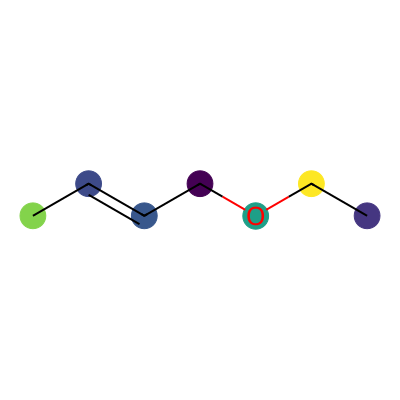

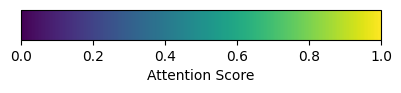

In [ ]:
drawMoleculeWithAttention(smiles,clean_smiles,aggregated_attentions)

## SMILES to look into:
### Looking into attention differences in symmetrical molecules:

1) c1cc2ccc3cccc4ccc(c1)c2c34 (Highly symmetrical (4 benzol rings))

2) O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl (Also very symmetrical, espc. Ns, Cls and Os in similar positions interesting to compare attention)

3) c1ccc(-c2ccc(-c3ccccc3)cc2)cc1 (three benzol rings in a chain)

4) c1ccc2c(c1)sc1ccccc12 (2 benzol rings, one five-ring )

### Looking into differences in hydrophobicity:

5) C1=CC=CC=C1 (Benzol, Solubility in water: 1.84 g/L (30 °C) (see: https://en.wikipedia.org/wiki/Benzene))

6) CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O (Aspirin, Solubility in water 3g/L (see: https://en.wikipedia.org/wiki/Aspirin))

7) C1=CC(=CC=C1C(=O)O)O (PHBA (found in: https://www.sciencedirect.com/science/article/pii/S095965262030247X#fig1), Solubility in Water 5g/L at 25 °C (https://pubchem.ncbi.nlm.nih.gov/compound/135#section=Melting-Point))

8) CCCCOC(=O)C1=CC=C(C=C1)N (Butyl 4-aminobenzoate (see: https://pubchem.ncbi.nlm.nih.gov/compound/2482#section=Melting-Point), Solubility in Water: 0.14g/L (no temperature stated))